In [189]:
import pickle as pkl
import numpy as np
from typing import Dict
import os
import xarray as xr
%load_ext autoreload
%autoreload 2
from basic_functions import *
import itertools
import datetime as dt
import plotly.graph_objects as go
import echopype as ep
from shapely.geometry import Point, Polygon
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [172]:
np.set_printoptions(threshold=10000)

In [171]:
# display_all_trajectories_folder("../data/acoustic_data/18kHz/processed_data/fall/18kHz_v1_fall.pkl", save=True, dest_path= "../data/figures/trajectories_by_season/with australia/")

In [170]:

# filter_by_bathymetry("../data/acoustic_data/18kHz/processed_data/by_day/18kHz_v1_summer_cropped_24h.pkl", "../data/acoustic_data/18kHz/processed_data/by_day/filtered_bathymetry/")

In [169]:
# display_all_trajectories_folder("../data/acoustic_data/18kHz/processed_data/by_day/filtered_bathymetry/18kHz_v1_spring_cropped_24h_filtered_bathymetry.pkl", save=True, dest_path= "../data/figures/trajectories_by_season/filtered_bathymetry/")

In [168]:
# put_label_inROI_outROI("../data/acoustic_data/18kHz/processed_data/by_day/filtered_bathymetry/18kHz_v1_summer_cropped_24h_filtered_bathymetry.pkl", "../data/acoustic_data/18kHz/processed_data/by_day/filtered_bathymetry/labelled/")

In [221]:
def get_mean_var_in_out_ROI(src_path:str, channel:int=0)-> Tuple[float, float]:
    mean_in_ROI, mean_out_ROI = np.zeros(240), np.zeros(240)
    std_in_ROI, std_out_ROI = np.zeros(240), np.zeros(240)
    count = 0

    with open(src_path, 'rb') as pkl_file : 
        while True :
            try : 
                _, data_dict = pkl.load(pkl_file)
                d = data_dict["DEPTH"]
                in_ROI = data_dict["in_ROI"]
                Sv = data_dict["Sv"]
                Sv = 10 * np.log10(Sv)
                if Sv.ndim>2 : 
                    Sv = Sv[:,:,channel]
                mean_Sv = np.nanmean(Sv, axis=0)
                std_Sv = np.nanstd(Sv, axis=0)
                
                assert (mean_Sv.shape == mean_in_ROI.shape)
                assert(std_Sv.shape == std_in_ROI.shape)

                if in_ROI : 
                    mean_in_ROI+= mean_Sv
                    std_in_ROI+= std_Sv

                else : 
                    mean_out_ROI+=mean_Sv
                    std_out_ROI+=std_Sv

                count+=1

            except EOFError :
                print("end of file")
                # Normalization
                mean_in_ROI, mean_out_ROI = mean_in_ROI/count, mean_out_ROI/count
                std_in_ROI, std_out_ROI = std_in_ROI/count, std_out_ROI/count
                return d, (mean_in_ROI, std_in_ROI), (mean_out_ROI, std_out_ROI)


In [222]:
d, in_ROI, out_ROI = get_mean_var_in_out_ROI("../data/acoustic_data/18kHz/processed_data/by_day/filtered_bathymetry/labelled/18kHz_v1_summer_cropped_24h_filtered_bathymetry_labelled.pkl")
print("in ROI : ", in_ROI)
print("out ROI : ", out_ROI)

/tmp/ipykernel_5113/2422728839.py:16: RuntimeWarning: Mean of empty slice
  mean_Sv = np.nanmean(Sv, axis=0)
/home/elise/miniconda3/envs/interactiveGUI/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


end of file
in ROI :  (array([                nan,                 nan, -3.712927340544395 ,
       -4.0881784254613205, -4.2723318132460495, -4.281954703924203 ,
       -4.231187492157739 , -4.154689823234738 , -4.0906433017974715,
       -4.032909102613617 , -4.002079451563212 , -3.973843836009012 ,
       -3.9632361129365954, -3.9414005912610195, -3.9244686509823126,
       -3.8728860299147727, -3.812585465638268 , -3.732406604033405 ,
       -3.6632322198433775, -3.6079926065588213, -3.5718451125307684,
       -3.5369457418863233, -3.5111750945170837, -3.480505467322786 ,
       -3.4605411385181966, -3.4413724848219744, -3.4308580102221087,
       -3.4209064063600163, -3.4137499184393967, -3.406972439170398 ,
       -3.4068328998633506, -3.4067205752100227, -3.4058992513202684,
       -3.403721275923777 , -3.4012323327841436, -3.3967927362079973,
       -3.3926749298556644, -3.389422617527137 , -3.3859018108803993,
       -3.386950925514763 , -3.389243377389259 , -3.391179790191468

In [273]:
def boxplot_mean_std(depth: np.ndarray, inROI: Tuple[np.ndarray], outROI: Tuple[np.ndarray], save:bool=False, dest_path:str="") :
    mean_inROI, std_inROI = inROI
    mean_outROI, std_outROI = outROI
    
    # Création du graphique
    plt.figure(figsize=(10, 6))

    # Tracer le backscattering moyen avec les barres d'erreur (écart-type)
    plt.errorbar(mean_inROI, -depth, xerr=std_inROI, fmt='o', color='b', ecolor='r', capsize=3, label="Mean backscattering strenght in ROI")
    plt.errorbar(mean_outROI, -depth, xerr=std_outROI, fmt='o', color='g', ecolor='purple', capsize=3, label="Mean backscattering strenght out ROI")

    # plt.gca().invert_yaxis()
    # Ajouter des labels et un titre
    plt.ylabel("Depth (m)")
    plt.xlabel("Mean backscattering strength (dB re m⁻¹)")
    plt.title("Mean Backscattering strength (dB re m⁻¹) by depth (m)")
    plt.legend()

    # Afficher le graphique
    plt.grid(True)

    # Save
    if save : 
        fig_path = dest_path + "mean_Sv_by_depth_in_out_ROI_boxplot"
        plt.savefig(f"{fig_path}.png", dpi=300, bbox_inches="tight")

    plt.show()



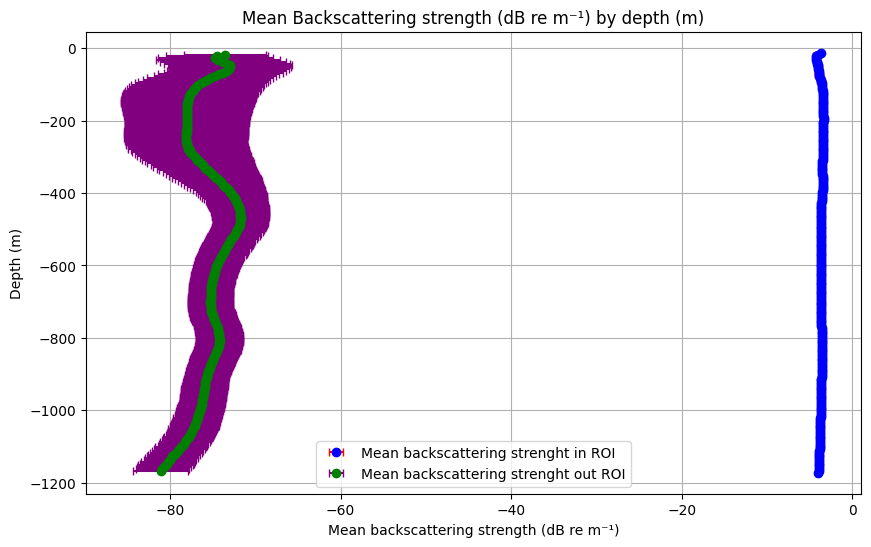

In [274]:
boxplot_mean_std(d, in_ROI, out_ROI, save=True, dest_path="../data/figures/mean_Sv_by_depth_in-out_ROI/")
